# SVM

### Dataset Information
No. of Features: 12  
No. of Instances: 4492  


### Table of Contents<a name='table of contents'></a>

1. [Data Ingestion](#data ingestion)
2. [Features & Target Arrays](#features and target arrays)
3. [Support Vector Machine](#svc)  
    a. [Classification Report](#classification report)  
    b. [Confusion Matrix](#confusion matrix)  
    c. [Class Balance](#class balance)
4. [Save Model](#pickle)

## Data Ingestion<a name='data ingestion'></a>

In [1]:
%matplotlib inline

import os
import json
import time
import pickle
import requests
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import yellowbrick as yb
sns.set_palette('RdBu', 10)

In [2]:
URL = 'https://raw.githubusercontent.com/georgetown-analytics/classroom-occupancy/master/models/sensor_data_ml.csv'

def fetch_data(fname='sensor_data_ml.csv'):
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Defining fetching data from the URL
DATA = fetch_data()

In [3]:
# Import sensor data
df = pd.read_csv('sensor_data_ml.csv', index_col='datetime', parse_dates=True)

In [4]:
# Rename columns
df.columns = ['temp', 'humidity', 'co2', 'light', 'light_st', 'noise',
              'bluetooth', 'images', 'door', 'occupancy_count', 'occupancy_level']

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4492 entries, 2017-03-25 09:05:00 to 2017-06-10 16:47:00
Data columns (total 11 columns):
temp               4492 non-null float64
humidity           4492 non-null float64
co2                4492 non-null float64
light              4492 non-null float64
light_st           4492 non-null float64
noise              4492 non-null float64
bluetooth          4492 non-null float64
images             4492 non-null float64
door               4492 non-null float64
occupancy_count    4492 non-null float64
occupancy_level    4492 non-null object
dtypes: float64(10), object(1)
memory usage: 421.1+ KB


,temp,humidity,co2,light,light_st,noise,bluetooth,images,door,occupancy_count,occupancy_level
datetime,,,,,,,,,,,
2017-03-25 09:05:00,22.600000,36.900000,781.000000,430.000000,1.0,511.000000,1.000000,15.242697,0.000000,0.000000,empty
2017-03-25 09:06:00,23.800000,38.954167,765.465279,428.533744,1.0,503.515931,11.399457,15.242697,0.000000,0.000000,empty
2017-03-25 09:07:00,23.850000,38.900000,768.458333,423.576500,1.0,510.548913,19.916667,15.242697,0.083333,4.416667,low
2017-03-25 09:08:00,23.900000,38.766667,777.791667,423.053571,1.0,506.504630,29.750000,15.242697,0.000000,23.416667,mid-level
2017-03-25 09:09:00,23.908333,38.733333,770.864583,438.607904,1.0,500.092672,35.860577,15.242697,0.000000,30.000000,high


### Features & Target Arrays<a name='features and target arrays'></a>

In [6]:
# Breakdown of classroom occupancy levels
df.occupancy_level.value_counts()

high         2881
mid-level     781
empty         482
low           348
Name: occupancy_level, dtype: int64

In [7]:
# Encode multiclass target variable
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit_transform(df['occupancy_level'])

array([0, 0, 2, ..., 2, 2, 2], dtype=int64)

In [8]:
# Create feature and target arrays
X = df.drop('occupancy_level', axis=1).values
y = df['occupancy_level']

In [9]:
# Use TimeSeriesSplit to create training and test set split indices
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## SVC<a name='svc'></a>

In [10]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Create a SVC classifer object: svc
svc = SVC().fit(X_train, y_train)

print('SVC Cross-Validation Scores')
cv_scores = cross_val_score(svc, X_train, y_train, cv=tscv)
print(cv_scores)
print('Average CV Score: {:.4f}'.format(np.mean(cv_scores)))

SVC Cross-Validation Scores
[ 0.76489028  0.63009404  0.71786834  0.74294671  0.57053292  0.70219436
  0.47021944  0.75548589  0.62695925  0.42633229  0.54231975  0.71473354]
Average CV Score: 0.6387


In [24]:
# Use TimeSeriesSplit to create training and test set split indices
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=8)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [25]:
from sklearn.metrics import classification_report

# Predict test set labels: y_pred
y_pred = svc.predict(X_test)

print(classification_report(y_test, y_pred))
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

             precision    recall  f1-score   support

      empty       1.00      0.03      0.06        63
       high       0.65      1.00      0.79       279
        low       1.00      0.40      0.57        68
  mid-level       1.00      0.48      0.65        89

avg / total       0.81      0.70      0.64       499

Training set score: 0.9990
Test set score: 0.7034


In [32]:
# Scale and tune hyperparameters using a SVM classifer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

pipe = Pipeline([('scaler', RobustScaler()),
                 ('clf', SVC())])

# Specify the hyperparameter space
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.00]

param_grid = [{'clf__kernel': ['linear'], 'clf__C': param_range, 'clf__class_weight': [None, 'balanced']},
              {'clf__kernel': ['rbf'], 'clf__C': param_range, 'clf__class_weight': [None, 'balanced'], 'clf__gamma': param_range}]
      
# Instantiate the GridSearchCV object: svc
svc = GridSearchCV(pipe, param_grid, cv=tscv)

# Fit to the training set
svc.fit(X_train, y_train)

print('Best Estimator:\n{}'.format(svc.best_estimator_))

Best Estimator:
Pipeline(steps=[('scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('clf', SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


In [33]:
print('SVM Model')
print('Best Score: {:.4f}'.format(svc.best_score_))
print('Best Parameters: {}'.format(svc.best_params_))

SVM Model
Best Score: 0.9320
Best Parameters: {'clf__kernel': 'linear', 'clf__C': 10.0, 'clf__class_weight': 'balanced'}


#### Classification Report<a name='classification report'></a>

In [34]:
# Use TimeSeriesSplit to create training and test set split indices
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=12)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [35]:
from sklearn.metrics import classification_report

# Predict test set labels: y_pred
y_pred = svc.predict(X_test)

print('SVM Classification Report: \n{}'.format(classification_report(y_test, y_pred)))
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

SVM Classification Report: 
             precision    recall  f1-score   support

      empty       1.00      1.00      1.00        61
       high       1.00      1.00      1.00       198
        low       1.00      1.00      1.00        41
  mid-level       1.00      1.00      1.00        45

avg / total       1.00      1.00      1.00       345

Training set score: 0.9932
Test set score: 1.0000


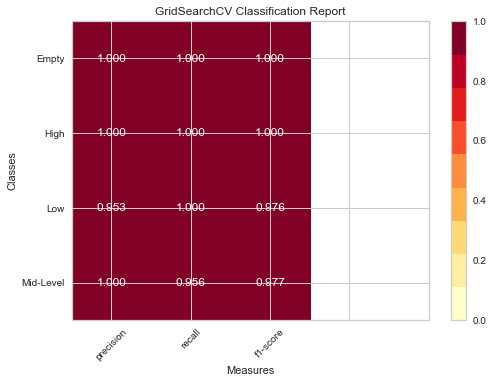

In [37]:
from yellowbrick.classifier import ClassificationReport
classes = ['Empty', 'High', 'Low', 'Mid-Level']

fig = plt.figure()
visualizer = ClassificationReport(svc, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
#fig.savefig('ml_graphs/svc_classification_report.png')

In [39]:
from sklearn.metrics import f1_score

print('SVC Multiclass Scores')
print('Micro average f1 score: {:.3f}'.format(f1_score(y_test, y_pred, average='micro')))
print('Weighted average f1 score: {:.3f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('Macro average f1 score: {:.3f}'.format(f1_score(y_test, y_pred, average='macro')))

SVC Multiclass Scores
Micro average f1 score: 1.000
Weighted average f1 score: 1.000
Macro average f1 score: 1.000


#### Confusion Matrix <a name='confusion matrix'></a>

In [40]:
from sklearn.metrics import confusion_matrix

print('SVC Confusion Matrix')
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

SVC Confusion Matrix
Confusion Matrix
[[ 61   0   0   0]
 [  0 198   0   0]
 [  0   0  41   0]
 [  0   0   0  45]]


#### Class Balance<a name='class balance'></a>

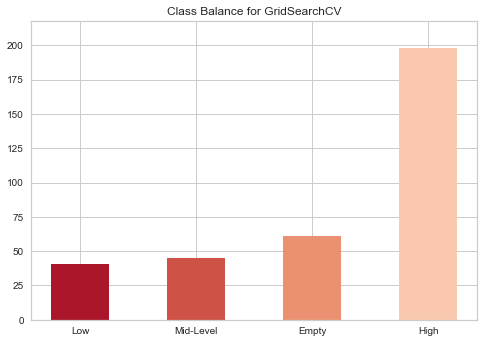

In [46]:
from yellowbrick.classifier import ClassBalance
classes = ['Empty', 'High', 'Low', 'Mid-Level']

fig = plt.figure()
visualizer = ClassBalance(svc, classes=classes)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g = visualizer.poof()
fig.savefig('ml_graphs/svc_class_balance.png')

## Save Model<a name='pickle'></a>

In [44]:
import pickle

svc_model = 'svc_model.sav'

# Save fitted model to disk
pickle.dump(svc, open(svc_model, 'wb'))

### [Return to Table of Contents](#table of contents)

In [45]:
loaded_model = pickle.load(open(svc_model, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.994202898551
